In [2]:
import stim, pymatching as pm, numpy as np
from IPython.display import SVG
import matplotlib.pyplot as plt

there were 133 wrong predictions (logical errors) out of 100000 shots. p_L = 0.133 %


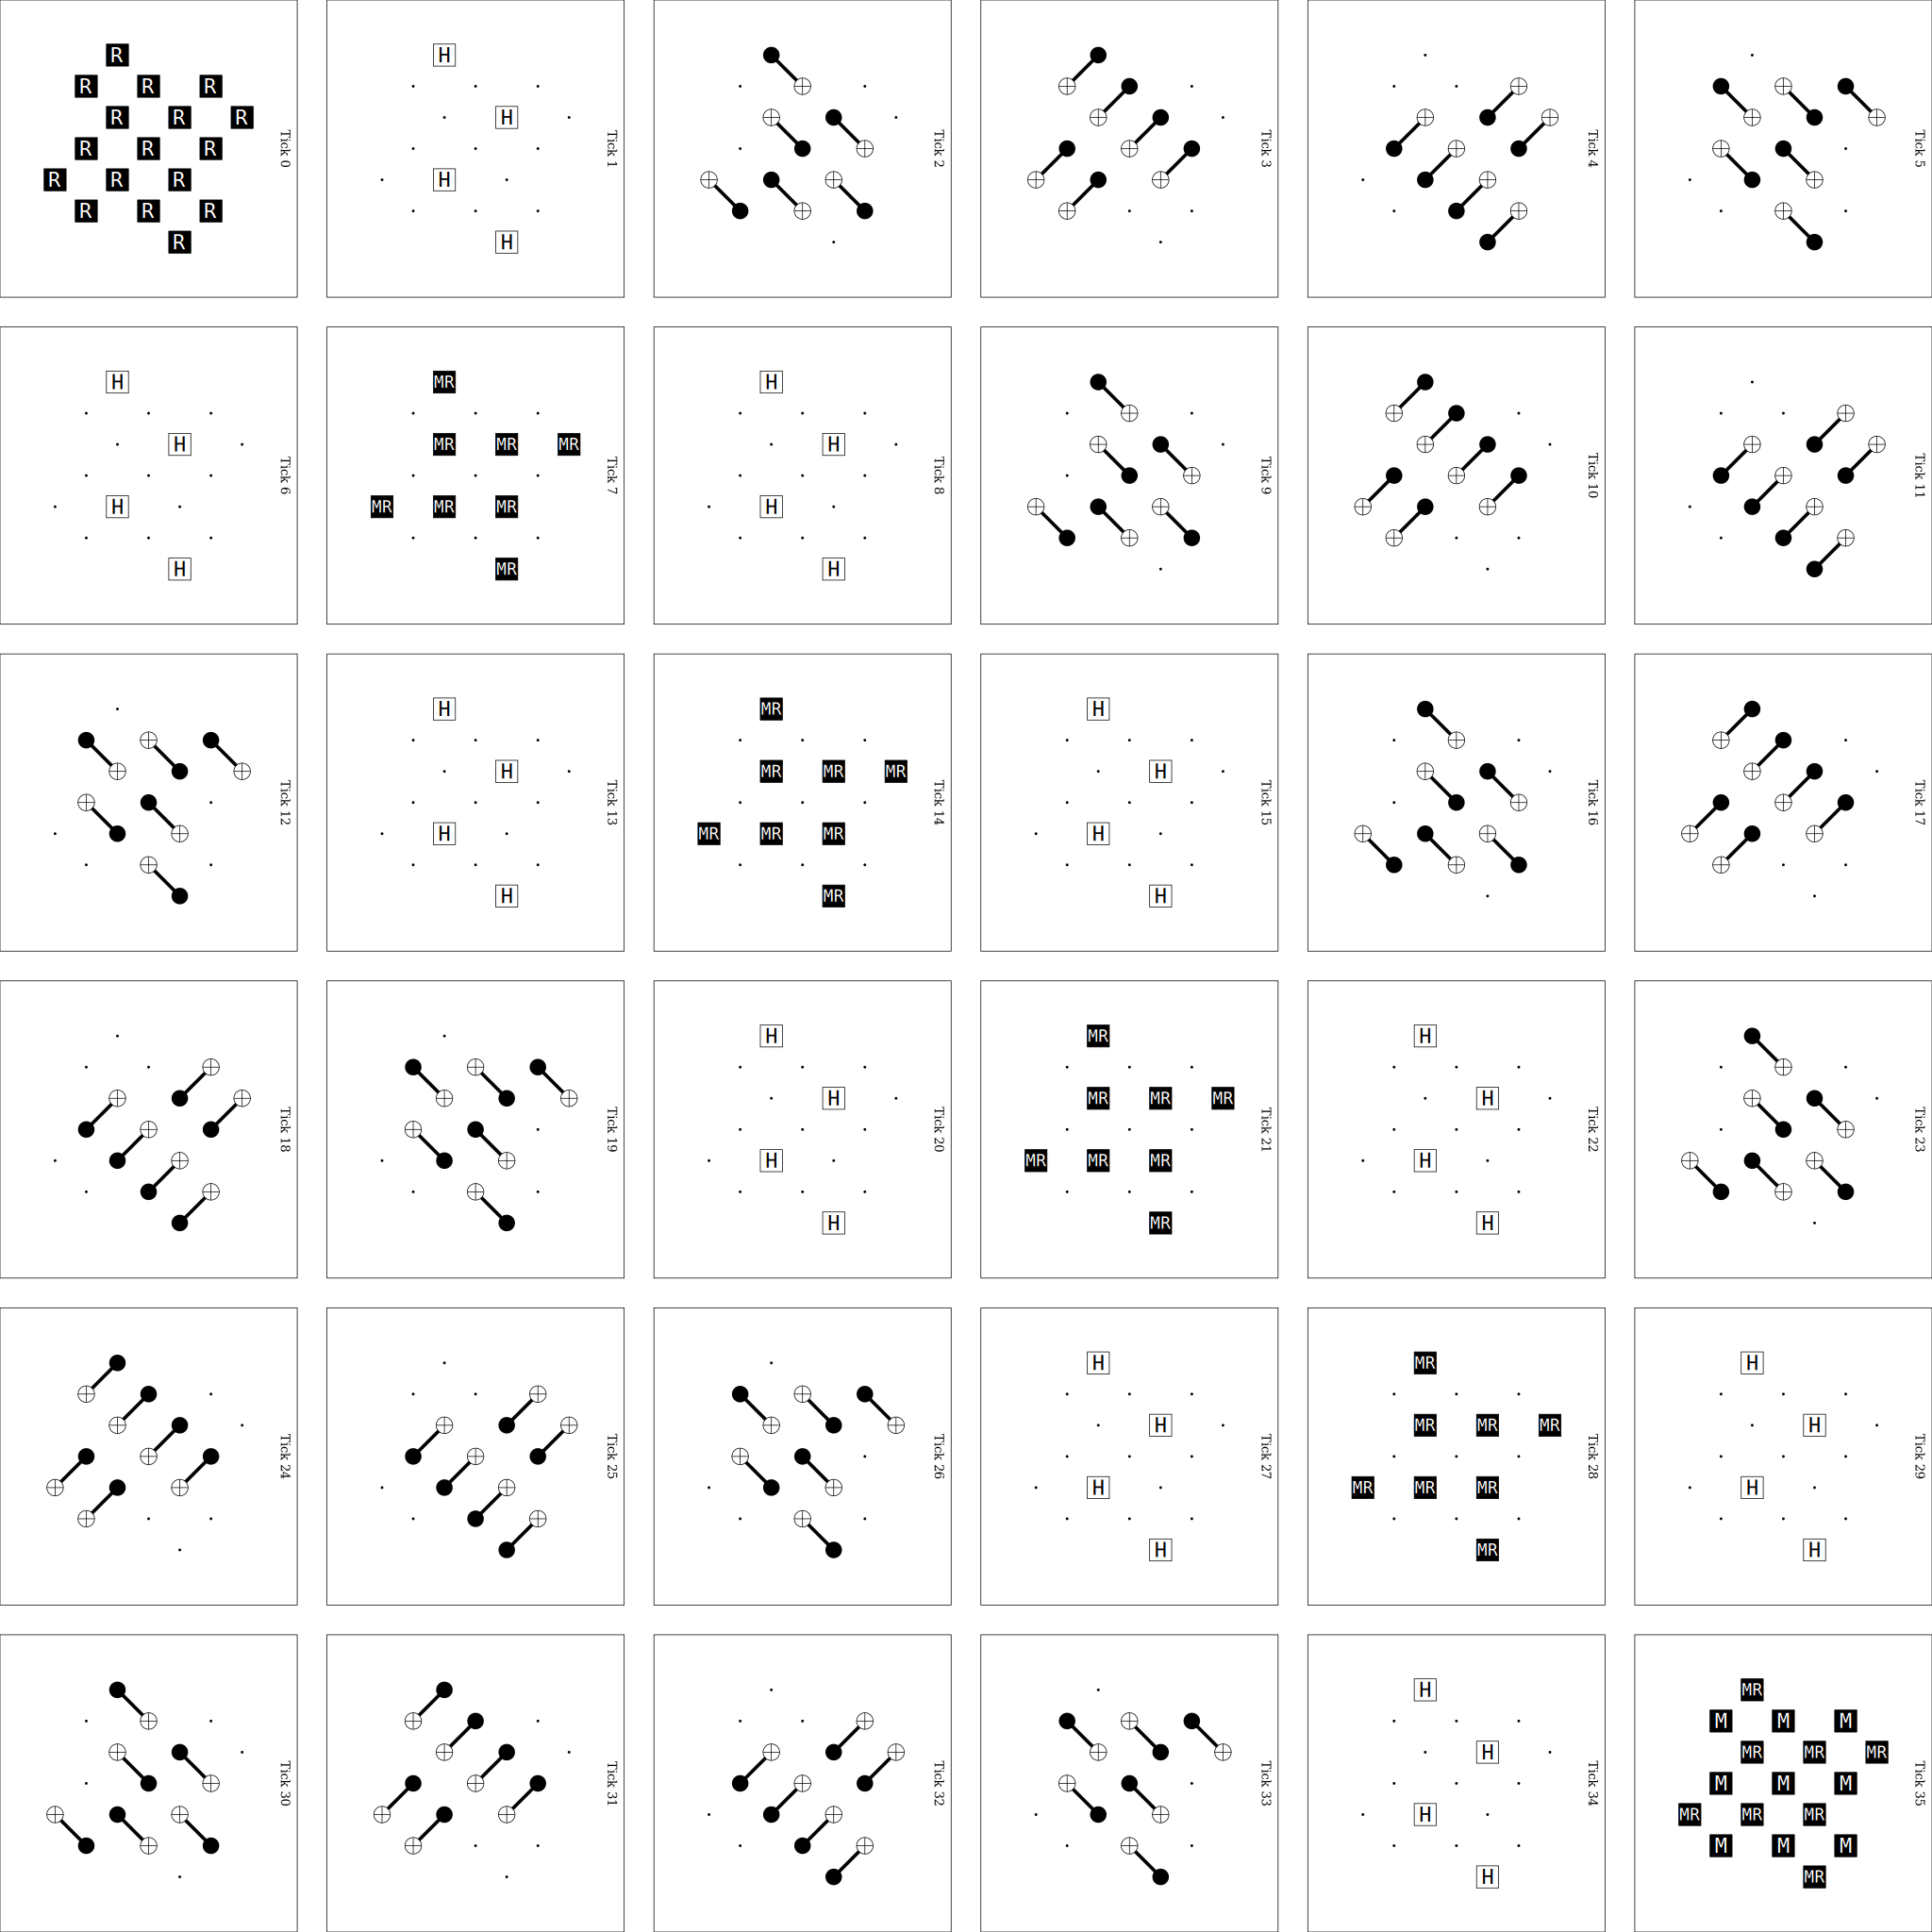

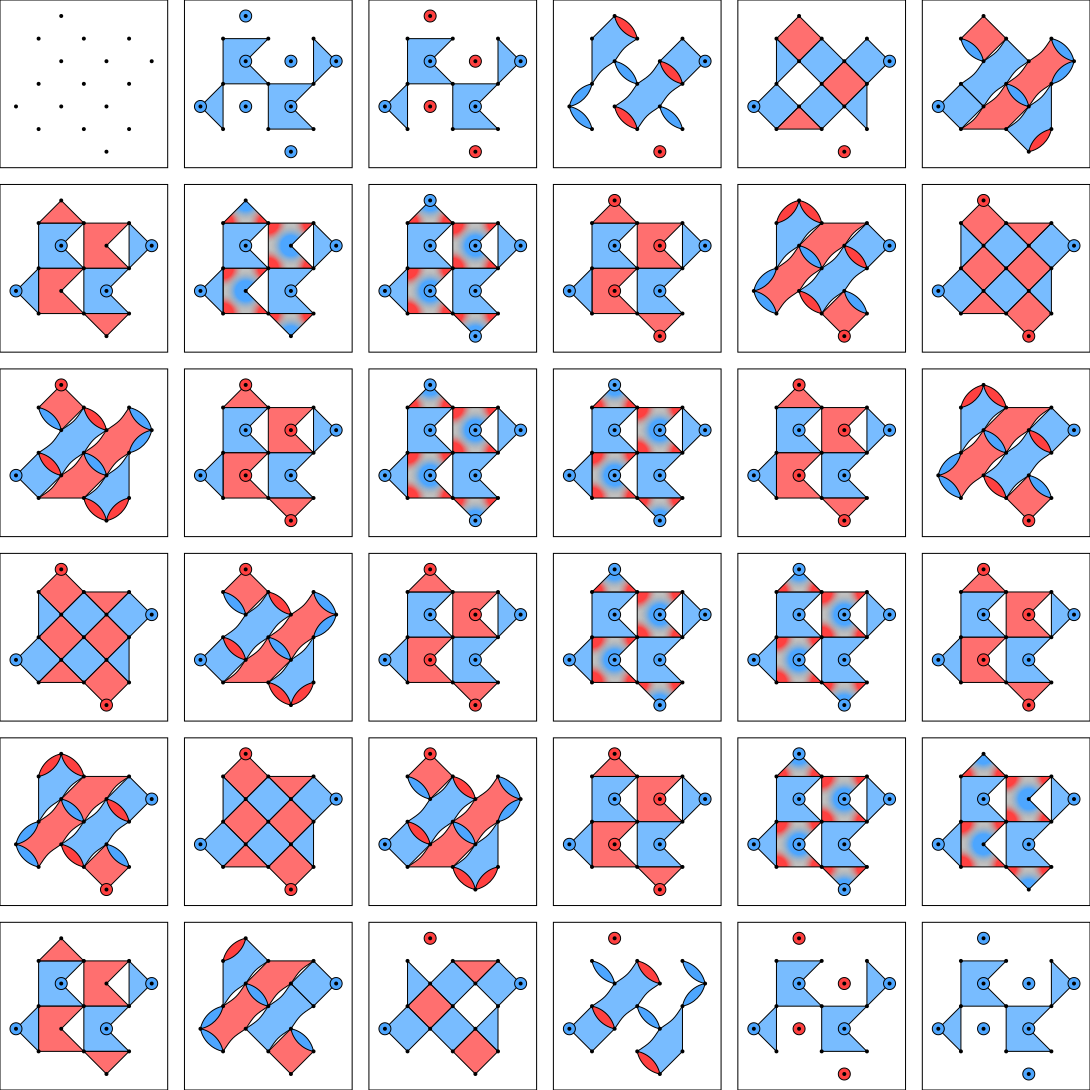

In [104]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pm.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

c = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=5,
    distance=3,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001)

num_shots = 100_000
num_logical_errors = count_logical_errors(c, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots. p_L =", round(num_logical_errors / num_shots * 100, 5), "%")

display(c.without_noise().diagram("timeslice-svg"))
display(c.without_noise().diagram("detslice-svg"))

